In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile
from IPython.display import display


In [2]:
raw = pd.DataFrame.from_csv('mean-stdev-raw.csv')
norm = pd.DataFrame.from_csv('mean-stdev-norm.csv')
intra = pd.DataFrame.from_csv('mean-stdev-intra.csv')
inter = pd.DataFrame.from_csv('mean-stdev-inter.csv')

tags = np.array(['P'] * 10 + ['S'] * 10)
labels = ['P', 'S']
dfs = [raw, norm, intra, inter]
colors = ['darkorange', 'r']

features = pd.concat(dfs, axis = 1)

numberOfShuffles = 500

sssCrossValTest = StratifiedShuffleSplit(n_splits = 1, test_size = 4)
sssTrainVal = StratifiedShuffleSplit(n_splits = numberOfShuffles, test_size = 4)
positiveLabel = 'S'

columnNames = ['Accuracy', 'F1', 'Precision', 'Recall', 'ROC AUC']


In [3]:
def calcAndPlotROCCurve(data, tags, ax = None, title = ''):
    fpr, tpr, thresholds = metrics.roc_curve(tags, data, pos_label = positiveLabel)
    roc_auc = metrics.auc(fpr, tpr)
    if not(ax is None):
        ax.plot(fpr, tpr, lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
        ax.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Random Guess')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC curve ' + title + ', Positive label = ' + positiveLabel)
        ax.legend(loc='lower right')
    return roc_auc

def highlight_3_yellow_3_normal(s):
#     return ['' for i, _ in enumerate(s)]
    return ['background-color: yellow' if 3 <= i % 6 <= 5 else '' for i, _ in enumerate(s)]


## Para cada feature, computar la curva ROC y graficarla

In [4]:
def univariate1a(df):
    numberOfColumns = len(df.columns)
    halfNumberOfColumns = numberOfColumns / 2
    _, axs = plt.subplots(halfNumberOfColumns, 2, figsize = (20, 5 * halfNumberOfColumns))
    for i, colName in enumerate(df.columns):
        try:
            calcAndPlotROCCurve(df[colName], tags, axs[i % halfNumberOfColumns][0 if i < halfNumberOfColumns else 1], colName)
        except Exception:
            calcAndPlotROCCurve(df[colName], tags, axs[i], colName)
    try:
        plt.tight_layout()
    except Exception:
        pass
    plt.show()


### Features: Mean and StDev para cada Banda de frecuencias para los datos desnormalizados

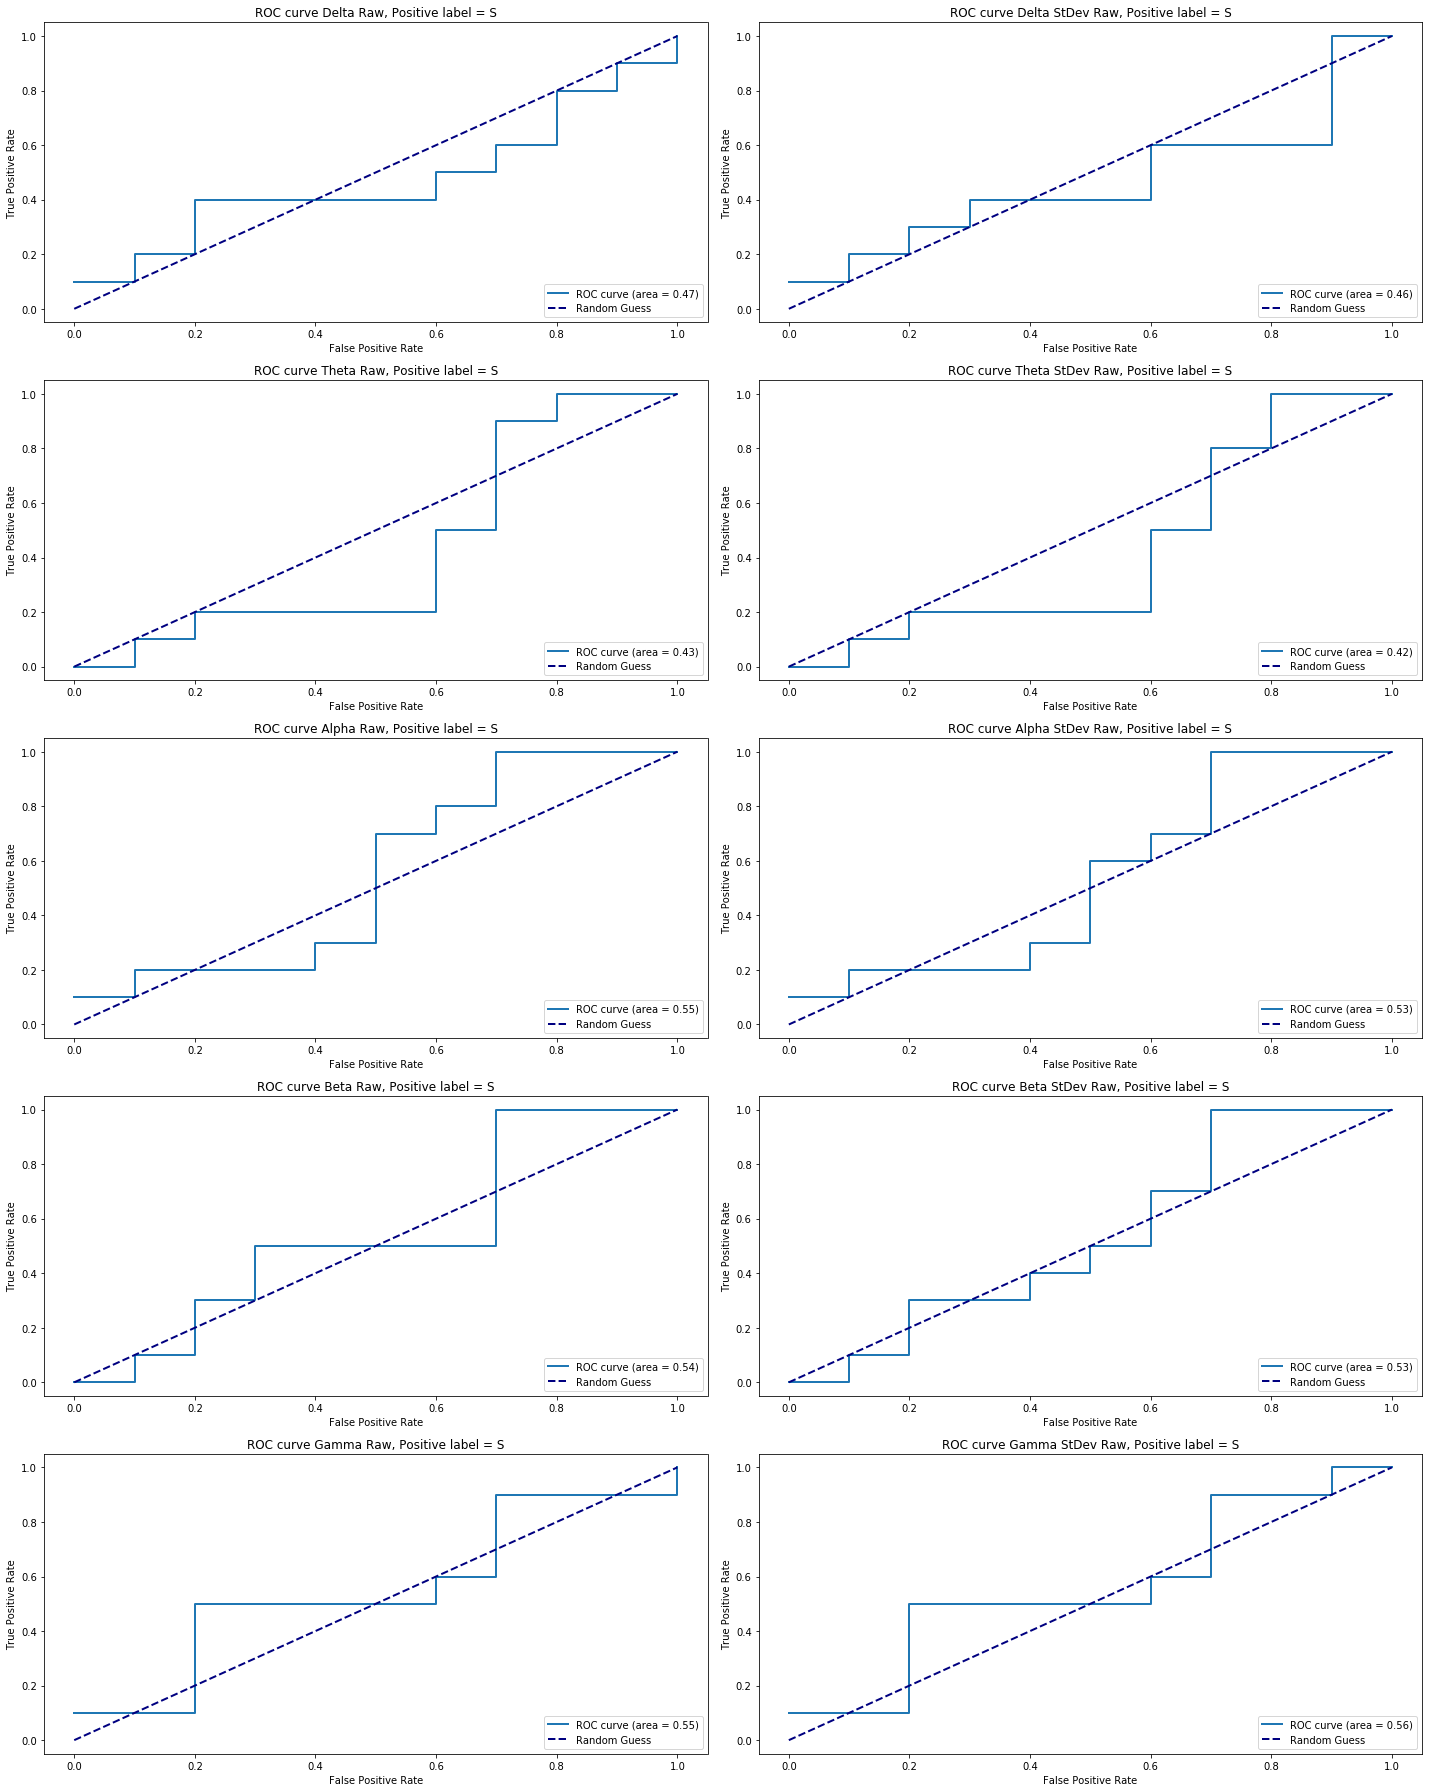

In [5]:
univariate1a(raw)


### Features: Mean and StDev para cada Banda de frecuencias para los datos normalizados

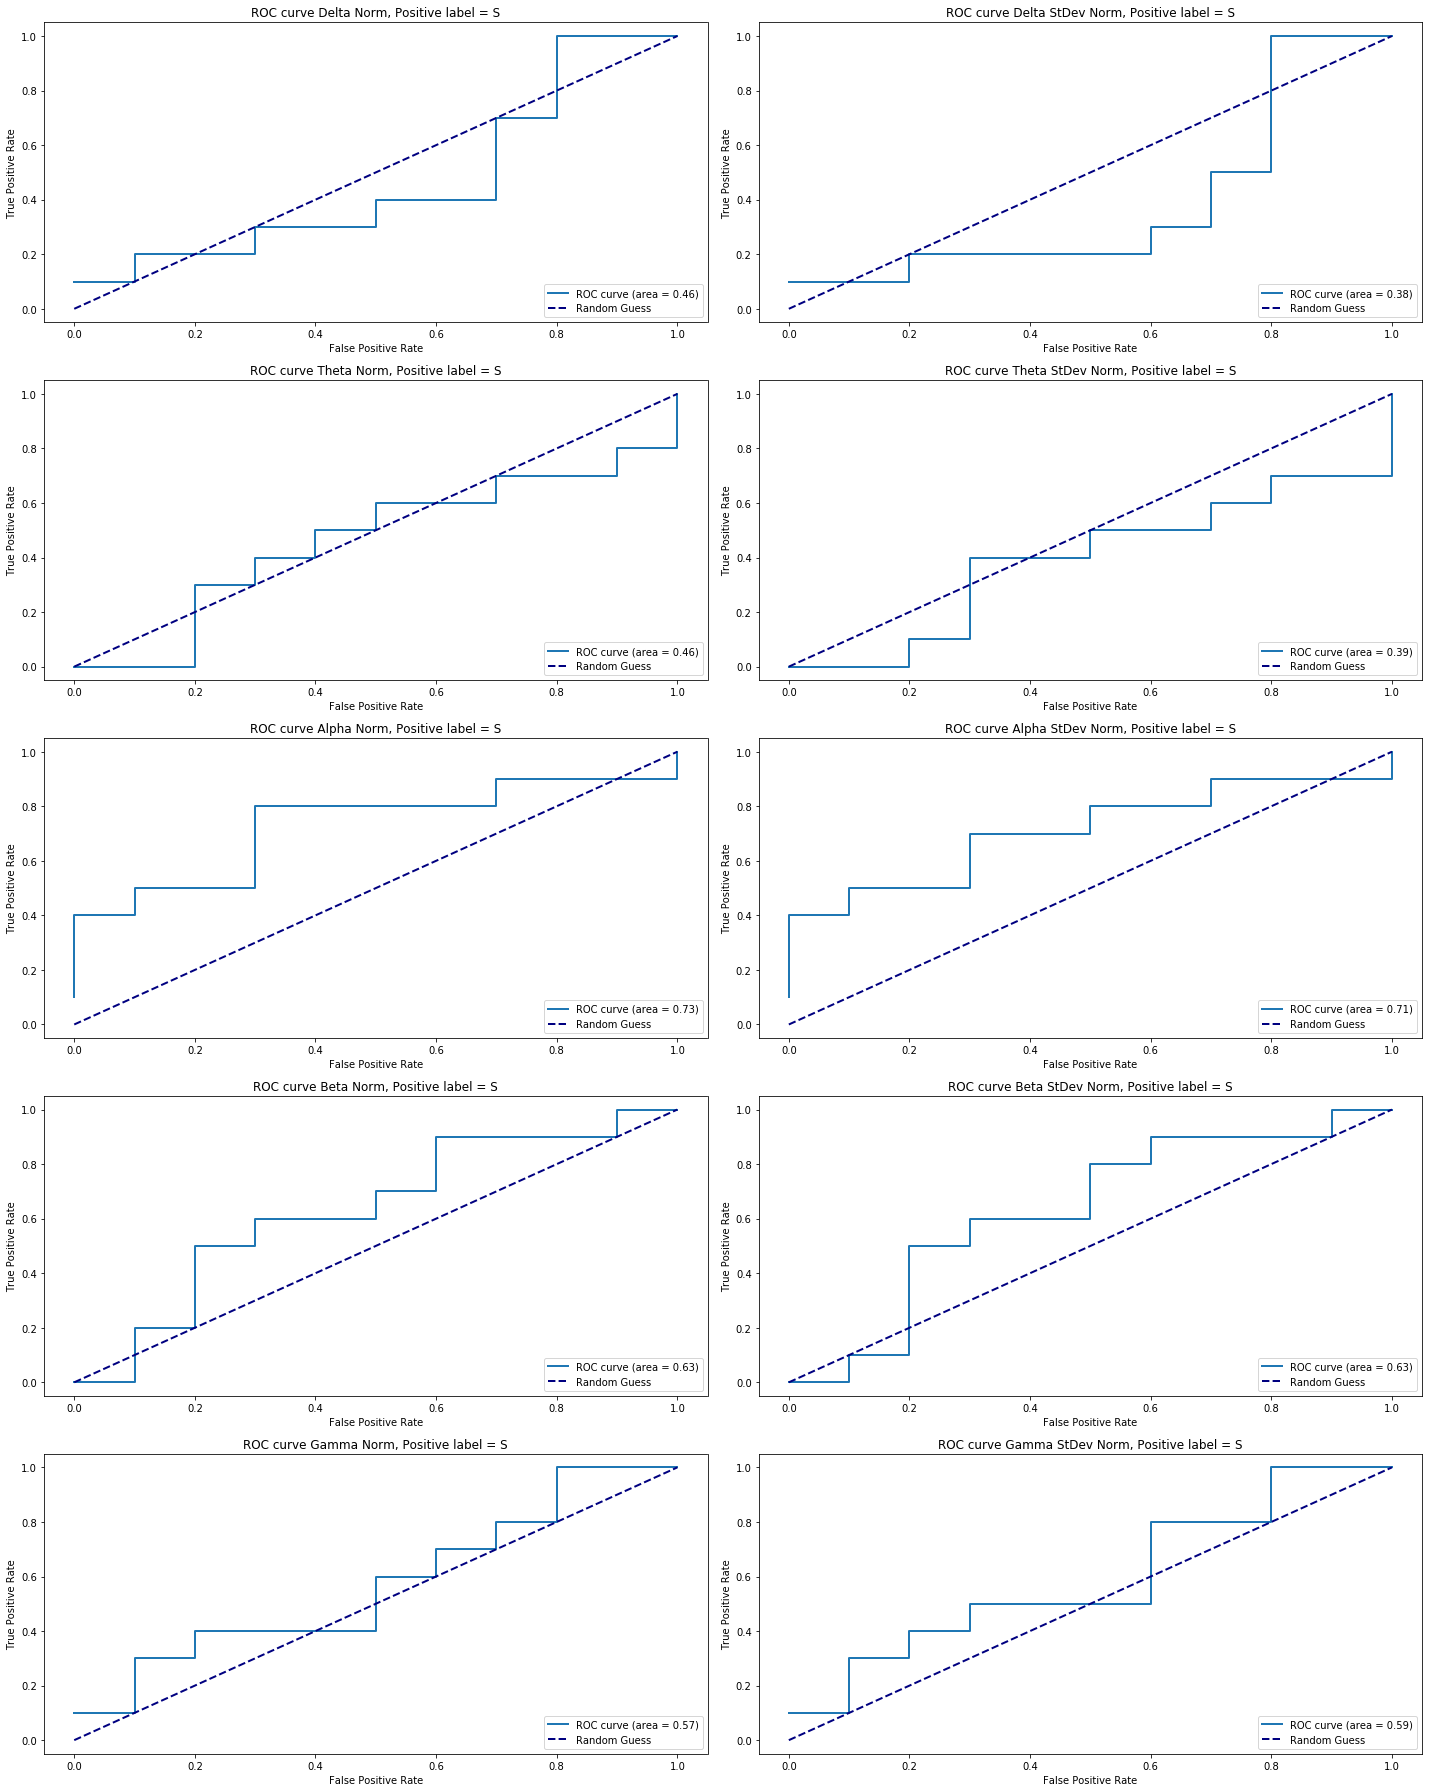

In [6]:
univariate1a(norm)


### Features: Mean and StDev para la medida intra-electrodo (entropía)

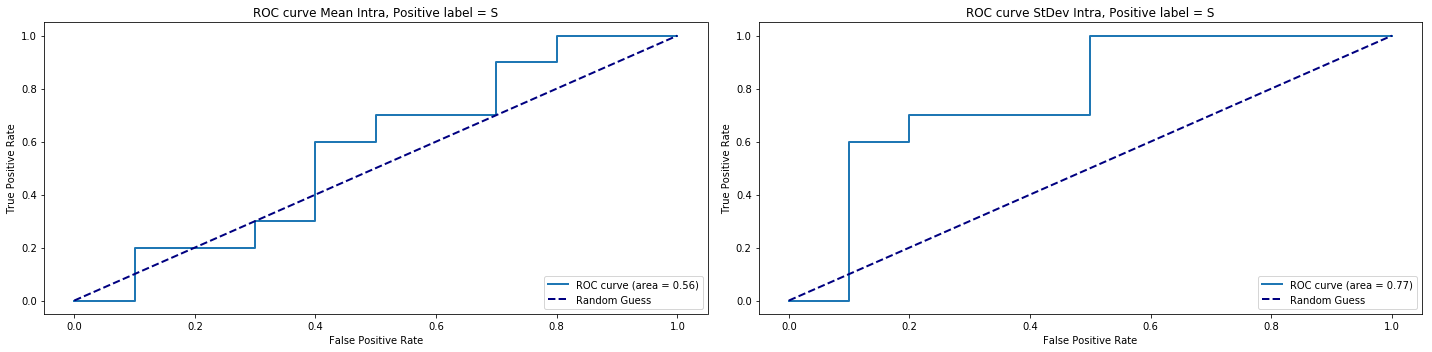

In [7]:
univariate1a(intra)


### Features: Mean and StDev para la medida inter-electrodo (entropía conjunta)

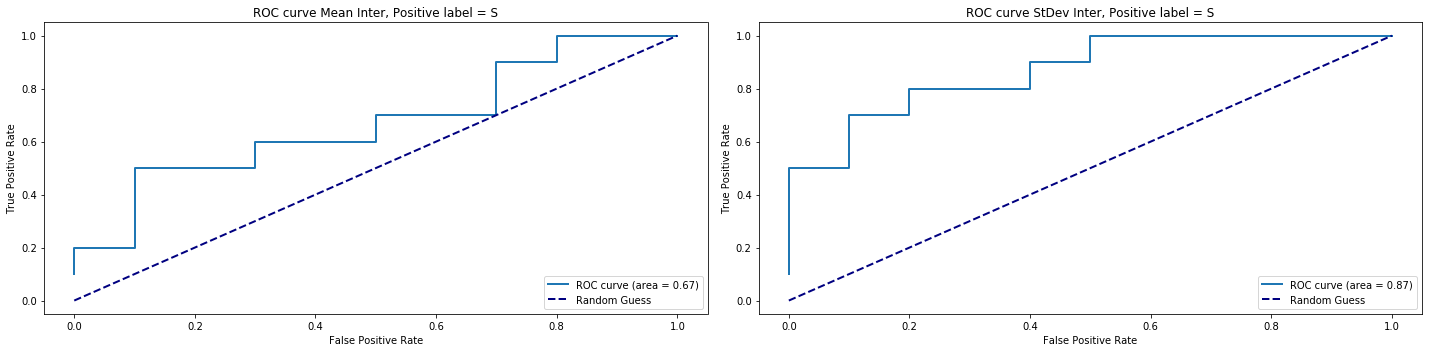

In [8]:
univariate1a(inter)


## Utilizando una técnica de cross validation, estimar la performance de un classificador Logistic Regression para cada feature y graficar la curva ROC correspondiente

In [9]:
def univariate1b(df):
    numberOfColumns = len(df.columns)
    halfNumberOfColumns = numberOfColumns / 2
    _, axs = plt.subplots(halfNumberOfColumns, 2, figsize = (20, 5 * halfNumberOfColumns))
    dataDF = pd.DataFrame(columns = columnNames)
    for i, colName in enumerate(df.columns):
        for cross_val_index, test_index in sssCrossValTest.split(df[colName], tags):
            X_cross_val, y_cross_val = df[colName].as_matrix()[cross_val_index], tags[cross_val_index]
            X_test, y_test = df[colName].as_matrix()[test_index], tags[test_index]

        accuracy, f1s, precisions, recalls, roc_aucs = [], [], [], [], []

        for train_index, val_index in sssTrainVal.split(X_cross_val, y_cross_val):
            X_train, y_train = X_cross_val[train_index], y_cross_val[train_index]
            X_val, y_val = X_cross_val[val_index], y_cross_val[val_index]

            clf = LogisticRegression()
            clf.fit(X_train.reshape(-1, 1), y_train)
            predictions = clf.predict(X_val.reshape(-1, 1))
            decision_function = clf.decision_function(X_val.reshape(-1, 1))

            accuracy.append(accuracy_score(y_val, predictions))
            f1s.append(f1_score(y_val, predictions, pos_label = positiveLabel))
            precisions.append(precision_score(y_val, predictions, pos_label = positiveLabel))
            recalls.append(recall_score(y_val, predictions, pos_label = positiveLabel))
            try:
                roc_aucs.append(calcAndPlotROCCurve(decision_function, y_val))
            except Exception:
                roc_aucs.append(calcAndPlotROCCurve(decision_function, y_val))

        clf = LogisticRegression()
        clf.fit(X_cross_val.reshape(-1, 1), y_cross_val)
        decision_function = clf.decision_function(X_test.reshape(-1, 1))
        predictions = clf.predict(X_test.reshape(-1, 1))

        try:
            roc_auc = calcAndPlotROCCurve(decision_function, y_test, axs[i % halfNumberOfColumns][0 if i < halfNumberOfColumns else 1], colName)
        except Exception:
            roc_auc = calcAndPlotROCCurve(decision_function, y_test, axs[i], colName)

        dataDF = dataDF.append(pd.Series( \
            { \
                columnNames[0]: np.mean(accuracy), \
                columnNames[1]: np.mean(f1s), \
                columnNames[2]: np.mean(precisions), \
                columnNames[3]: np.mean(recalls), \
                columnNames[4]: np.mean(roc_aucs) \
            }).rename(colName + ' Mean'))
        dataDF = dataDF.append(pd.Series( \
            { \
                columnNames[0]: np.std(accuracy), \
                columnNames[1]: np.std(f1s), \
                columnNames[2]: np.std(precisions), \
                columnNames[3]: np.std(recalls), \
                columnNames[4]: np.std(roc_aucs) \
            }).rename(colName + ' StDev'))
        dataDF = dataDF.append(pd.Series( \
            { \
                columnNames[0]: accuracy_score(y_test, predictions), \
                columnNames[1]: f1_score(y_test, predictions, pos_label = positiveLabel), \
                columnNames[2]: precision_score(y_test, predictions, pos_label = positiveLabel), \
                columnNames[3]: recall_score(y_test, predictions, pos_label = positiveLabel), \
                columnNames[4]: roc_auc \
            }).rename(colName + ' Test'))

    dataDF = dataDF.style.apply(highlight_3_yellow_3_normal)
    display(dataDF)
    try:
        plt.tight_layout()
    except Exception:
        pass
    plt.show()


### Features: Mean and StDev para cada Banda de frecuencias para los datos desnormalizados

/Users/personal/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/personal/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,F1,Precision,Recall,ROC AUC
Delta Raw Mean,0.5,0,0,0,0.5
Delta Raw StDev,0,0,0,0,0
Delta Raw Test,0.5,0,0,0,0.5
Theta Raw Mean,0.5,0,0,0,0.5
Theta Raw StDev,0,0,0,0,0
Theta Raw Test,0.5,0,0,0,0.5
Alpha Raw Mean,0.5,0,0,0,0.5
Alpha Raw StDev,0,0,0,0,0
Alpha Raw Test,0.5,0,0,0,0.5
Beta Raw Mean,0.5,0,0,0,0.5


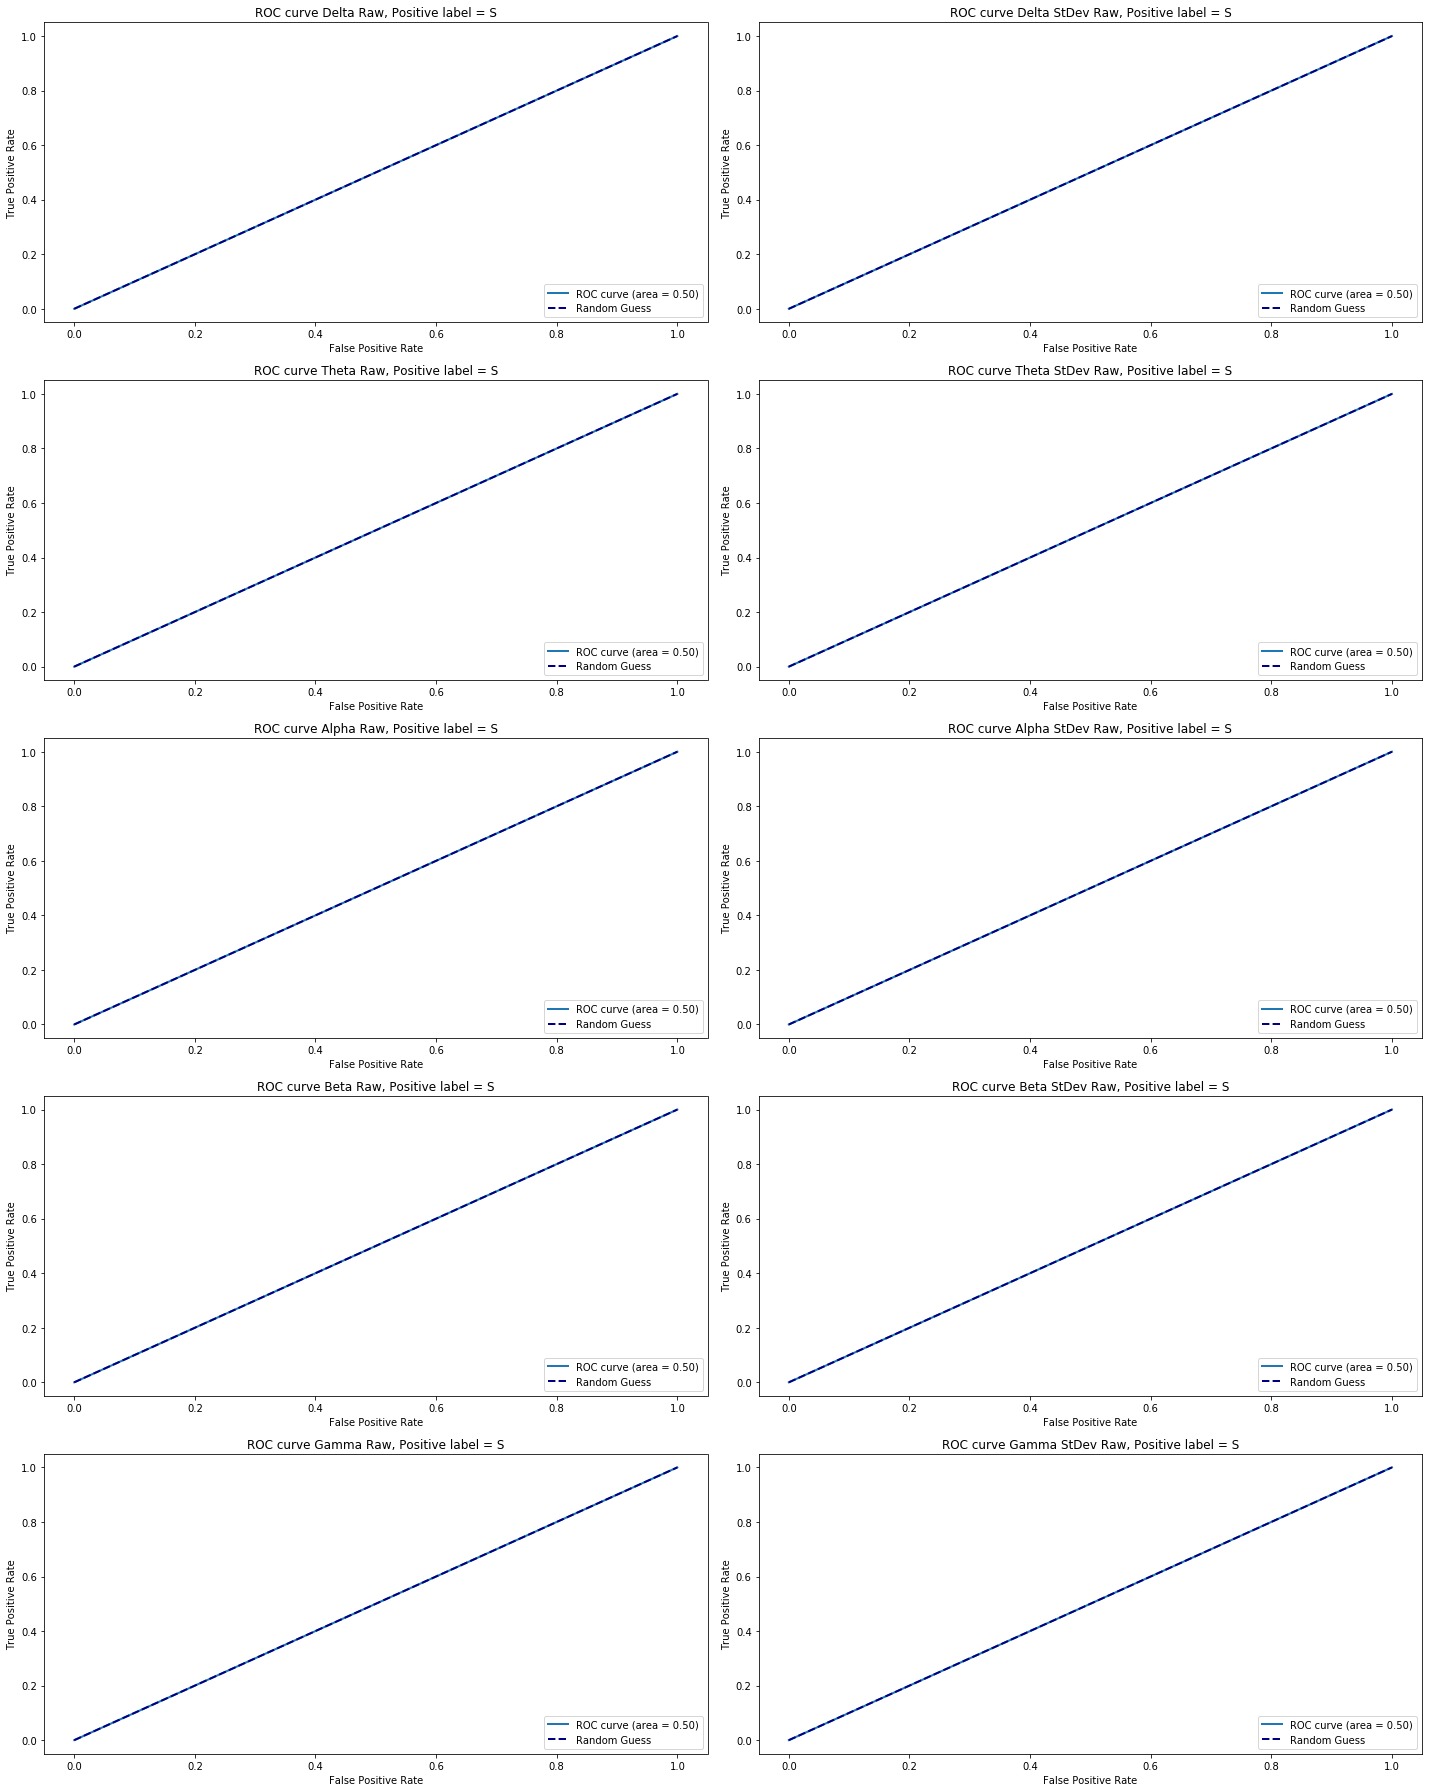

In [10]:
univariate1b(raw)


### Features: Mean and StDev para cada Banda de frecuencias para los datos normalizados

,Accuracy,F1,Precision,Recall,ROC AUC
Delta Norm Mean,0.361,0.288333,0.267333,0.333,0.3065
Delta Norm StDev,0.177282,0.265178,0.258585,0.32033,0.241211
Delta Norm Test,0.5,0,0,0,0.75
Theta Norm Mean,0.395,0.318733,0.315667,0.357,0.2985
Theta Norm StDev,0.179513,0.259226,0.29244,0.306677,0.216847
Theta Norm Test,0.25,0,0,0,0.5
Alpha Norm Mean,0.678,0.555067,0.691,0.494,0.7115
Alpha Norm StDev,0.197018,0.320518,0.401687,0.319318,0.274122
Alpha Norm Test,0.5,0.5,0.5,0.5,0.75
Beta Norm Mean,0.3555,0.378933,0.327,0.478,0.334


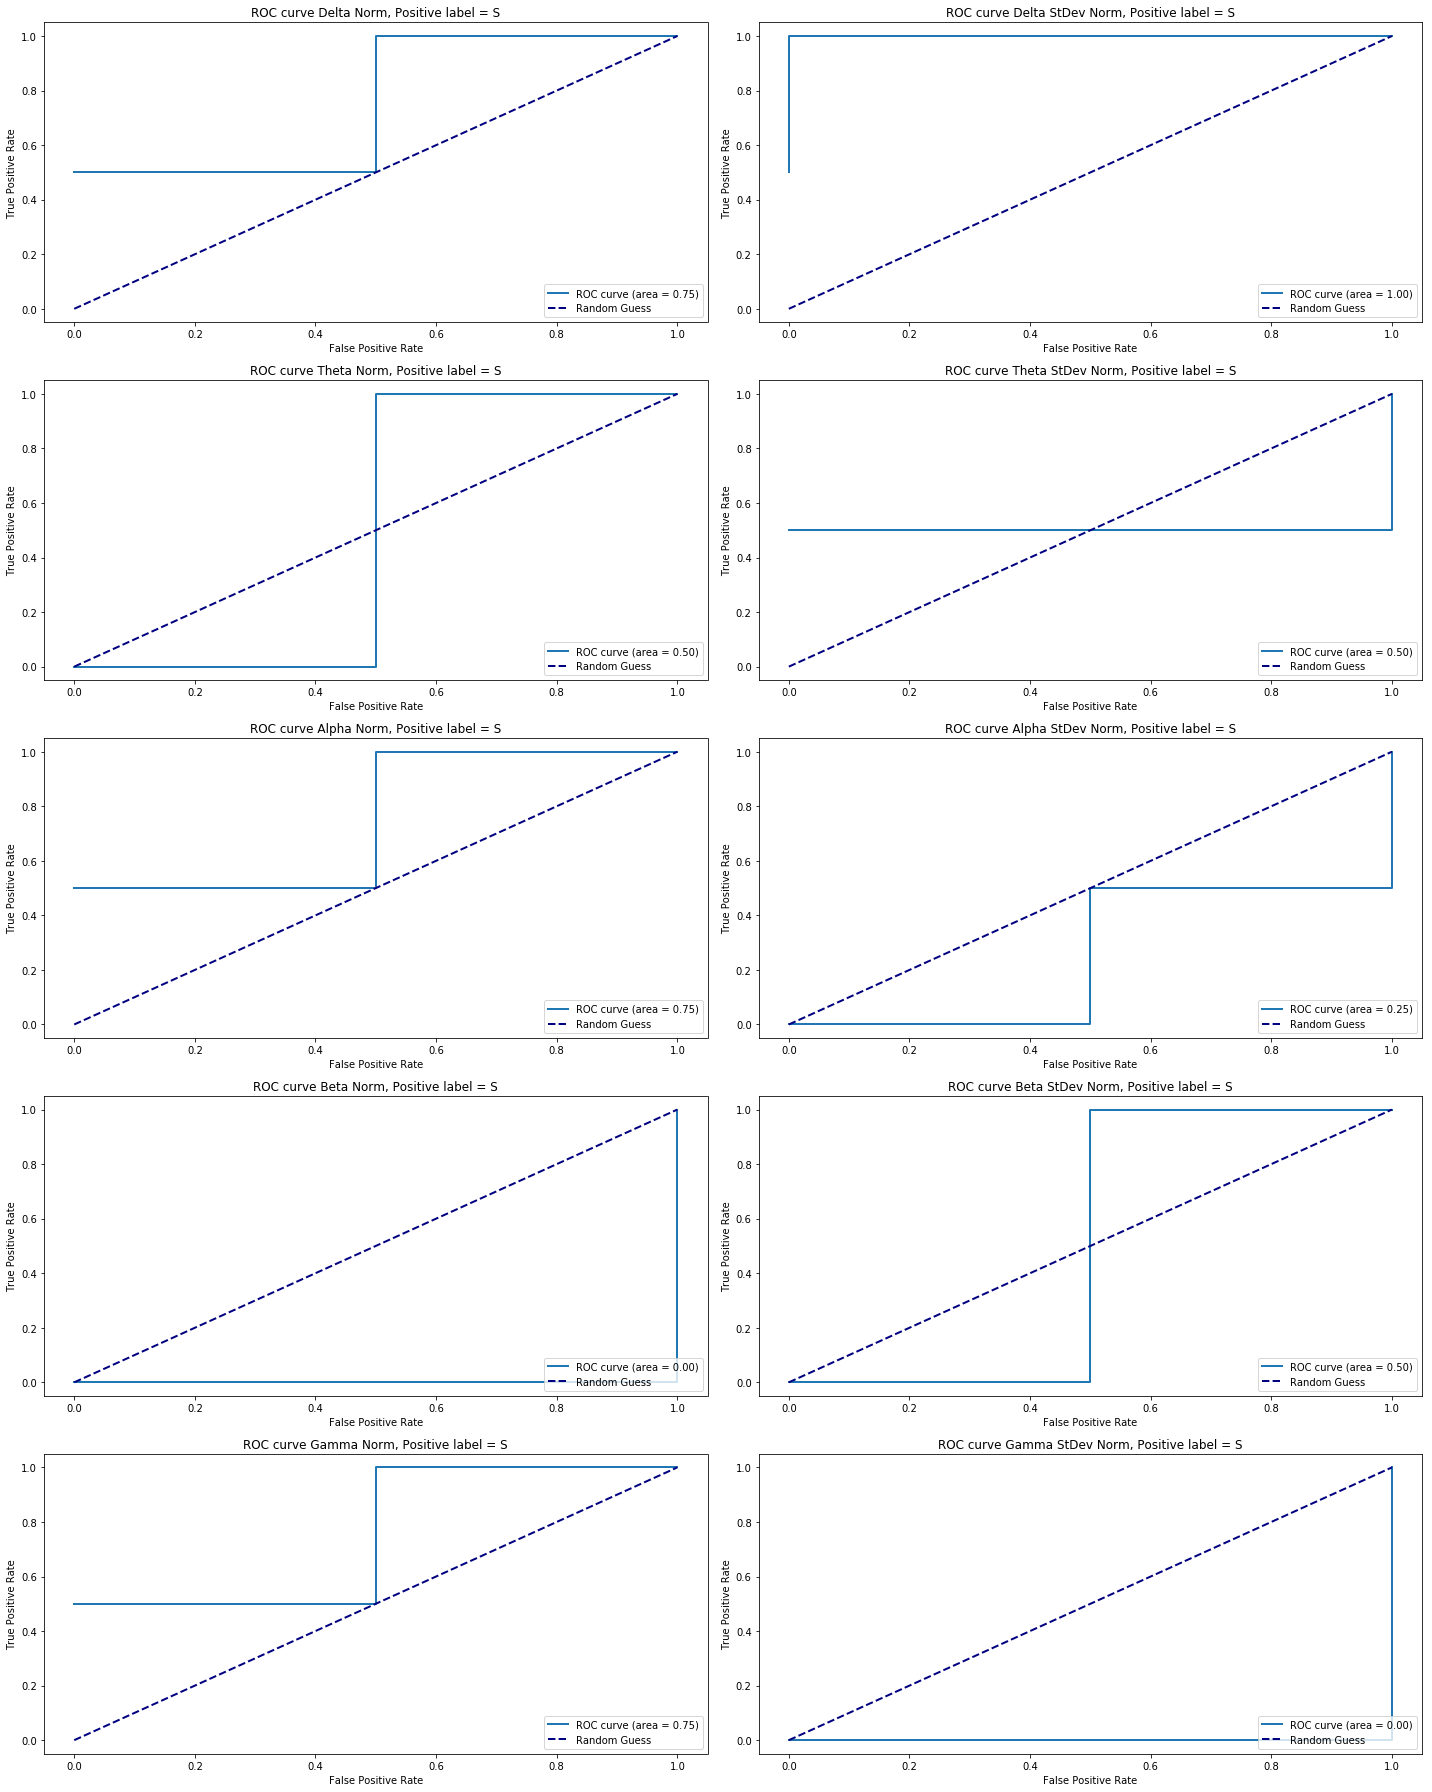

In [11]:
univariate1b(norm)


### Features: Mean and StDev para la medida intra-electrodo (entropía)

,Accuracy,F1,Precision,Recall,ROC AUC
Mean Intra Mean,0.417,0.410733,0.368667,0.497,0.387
Mean Intra StDev,0.188045,0.26859,0.249391,0.358456,0.283251
Mean Intra Test,0.5,0.666667,0.5,1,0.25
StDev Intra Mean,0.7245,0.7946,0.692667,0.982,0.7335
StDev Intra StDev,0.17457,0.119125,0.181633,0.093145,0.260965
StDev Intra Test,0.75,0.8,0.666667,1,1


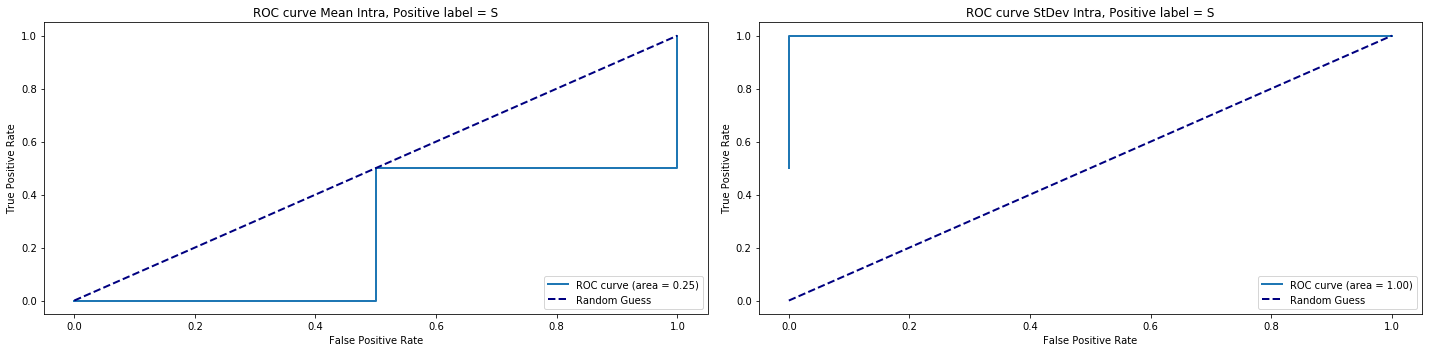

In [12]:
univariate1b(intra)


### Features: Mean and StDev para la medida inter-electrodo (entropía conjunta)

,Accuracy,F1,Precision,Recall,ROC AUC
Mean Inter Mean,0.474,0.559667,0.469333,0.727,0.6015
Mean Inter StDev,0.204509,0.219752,0.19106,0.319329,0.308744
Mean Inter Test,0.5,0.5,0.5,0.5,0.75
StDev Inter Mean,0.7295,0.720467,0.745,0.759,0.8465
StDev Inter StDev,0.19737,0.22962,0.266516,0.287087,0.19701
StDev Inter Test,0.75,0.8,0.666667,1,1


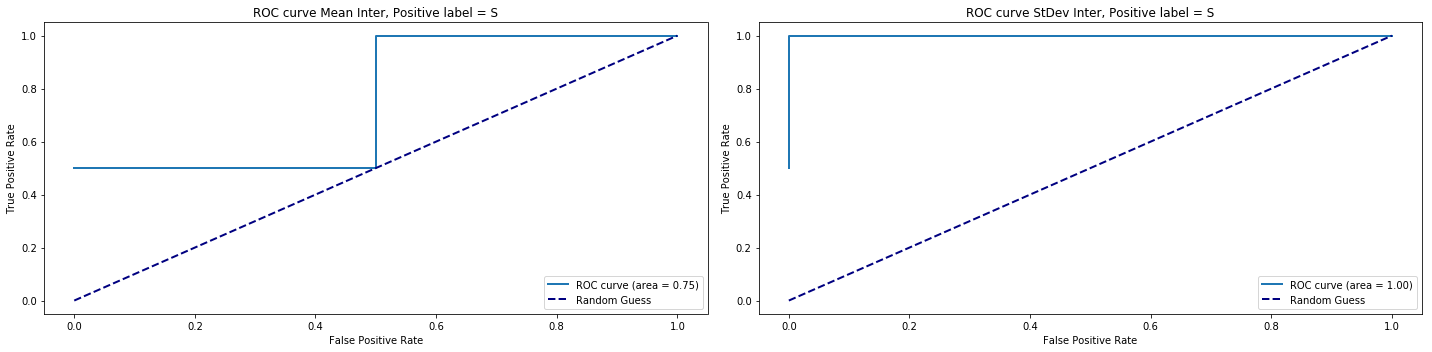

In [13]:
univariate1b(inter)


### ¿Cuál es su conclusión respecto a los resultados obtenidos en el punto anterior?

### Utilizar todos los features y entrenar un clasificador basado en Support Vector Machine. Computar la curva roc y graficarla. No olvidar reportar el area bajo la curva.

In [14]:
def multivariate2a(kernel):
    _, axs = plt.subplots(1, 1)
    dataDF = pd.DataFrame(columns = columnNames)

    for cross_val_index, test_index in sssCrossValTest.split(features, tags):
        X_cross_val, y_cross_val = features.as_matrix()[cross_val_index], tags[cross_val_index]
        X_test, y_test = features.as_matrix()[test_index], tags[test_index]

    accuracy, f1s, precisions, recalls, roc_aucs = [], [], [], [], []

    for train_index, val_index in sssTrainVal.split(X_cross_val, y_cross_val):
        X_train, y_train = X_cross_val[train_index], y_cross_val[train_index]
        X_val, y_val = X_cross_val[val_index], y_cross_val[val_index]

        clf = SVC(kernel = kernel)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_val)
        decision_function = clf.decision_function(X_val)

        accuracy.append(accuracy_score(y_val, predictions))
        f1s.append(f1_score(y_val, predictions, pos_label = positiveLabel))
        precisions.append(precision_score(y_val, predictions, pos_label = positiveLabel))
        recalls.append(recall_score(y_val, predictions, pos_label = positiveLabel))
        try:
            roc_aucs.append(calcAndPlotROCCurve(decision_function, y_val))
        except Exception:
            roc_aucs.append(calcAndPlotROCCurve(decision_function, y_val))

    clf = SVC(kernel = kernel)
    clf.fit(X_cross_val, y_cross_val)
    decision_function = clf.decision_function(X_test)
    predictions = clf.predict(X_test)

    dataDF = dataDF.append(pd.Series( \
        { \
            columnNames[0]: np.mean(accuracy), \
            columnNames[1]: np.mean(f1s), \
            columnNames[2]: np.mean(precisions), \
            columnNames[3]: np.mean(recalls), \
            columnNames[4]: np.mean(roc_aucs) \
        }).rename('Mean'))
    dataDF = dataDF.append(pd.Series( \
        { \
            columnNames[0]: np.std(accuracy), \
            columnNames[1]: np.std(f1s), \
            columnNames[2]: np.std(precisions), \
            columnNames[3]: np.std(recalls), \
            columnNames[4]: np.std(roc_aucs) \
        }).rename('StDev'))
    dataDF = dataDF.append(pd.Series( \
        { \
            columnNames[0]: accuracy_score(y_test, predictions), \
            columnNames[1]: f1_score(y_test, predictions, pos_label = positiveLabel), \
            columnNames[2]: precision_score(y_test, predictions, pos_label = positiveLabel), \
            columnNames[3]: recall_score(y_test, predictions, pos_label = positiveLabel), \
            columnNames[4]: calcAndPlotROCCurve(decision_function, y_test, axs) \
        }).rename('Test'))

    dataDF = dataDF.style.apply(highlight_3_yellow_3_normal)
    display(dataDF)
    try:
        plt.tight_layout()
    except Exception:
        pass
    plt.show()


,Accuracy,F1,Precision,Recall,ROC AUC
Mean,0.48,0.405667,0.418,0.429,0.5175
StDev,0.199625,0.27939,0.32102,0.312184,0.309142
Test,0.5,0.666667,0.5,1,0.5


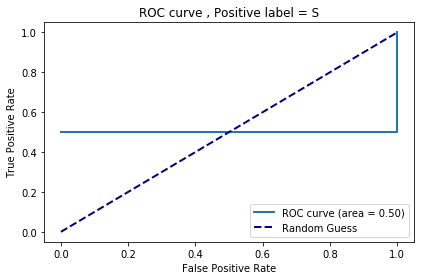

In [15]:
multivariate2a('linear')


### Repetir, pero utilizando un pipeline de Scikit-Learn con los siguientes 3 pasos:

1. Standard Scaler
2. Feature Selection utilizando solo el 10%.
3. SVC

In [16]:
def multivariate2b(percentile, kernel):
    _, axs = plt.subplots(1, 1)
    dataDF = pd.DataFrame(columns = columnNames)

    for cross_val_index, test_index in sssCrossValTest.split(features, tags):
        X_cross_val, y_cross_val = features.as_matrix()[cross_val_index], tags[cross_val_index]
        X_test, y_test = features.as_matrix()[test_index], tags[test_index]

    accuracy, f1s, precisions, recalls, roc_aucs = [], [], [], [], []

    for train_index, val_index in sssTrainVal.split(X_cross_val, y_cross_val):
        X_train, y_train = X_cross_val[train_index], y_cross_val[train_index]
        X_val, y_val = X_cross_val[val_index], y_cross_val[val_index]

        ss = StandardScaler()
        fs = SelectPercentile(percentile = percentile)
        clf = SVC(kernel = kernel)
        steps = [('Standard Scaler', ss), ('Feature Selection', fs), ('SVM', clf)]
        pipe = Pipeline(steps)
        pipe.fit(X_train, y_train)
        predictions = pipe.predict(X_val)

        transformed = fs.transform(X_val)
        decision_function = clf.decision_function(transformed)

        accuracy.append(accuracy_score(y_val, predictions))
        f1s.append(f1_score(y_val, predictions, pos_label = positiveLabel))
        precisions.append(precision_score(y_val, predictions, pos_label = positiveLabel))
        recalls.append(recall_score(y_val, predictions, pos_label = positiveLabel))
        try:
            roc_aucs.append(calcAndPlotROCCurve(decision_function, y_val))
        except Exception:
            roc_aucs.append(calcAndPlotROCCurve(decision_function, y_val))

    ss = StandardScaler()
    fs = SelectPercentile(percentile = percentile)
    clf = SVC(kernel = kernel)
    steps = [('Standard Scaler', ss), ('Feature Selection', fs), ('SVM', clf)]
    pipe = Pipeline(steps)
    pipe.fit(X_cross_val, y_cross_val)

    predictions = pipe.predict(X_test)
    decision_function = pipe.decision_function(X_test)

    dataDF = dataDF.append(pd.Series( \
        { \
            columnNames[0]: np.mean(accuracy), \
            columnNames[1]: np.mean(f1s), \
            columnNames[2]: np.mean(precisions), \
            columnNames[3]: np.mean(recalls), \
            columnNames[4]: np.mean(roc_aucs) \
        }).rename('Mean'))
    dataDF = dataDF.append(pd.Series( \
        { \
            columnNames[0]: np.std(accuracy), \
            columnNames[1]: np.std(f1s), \
            columnNames[2]: np.std(precisions), \
            columnNames[3]: np.std(recalls), \
            columnNames[4]: np.std(roc_aucs) \
        }).rename('StDev'))
    dataDF = dataDF.append(pd.Series( \
        { \
            columnNames[0]: accuracy_score(y_test, predictions), \
            columnNames[1]: f1_score(y_test, predictions, pos_label = positiveLabel), \
            columnNames[2]: precision_score(y_test, predictions, pos_label = positiveLabel), \
            columnNames[3]: recall_score(y_test, predictions, pos_label = positiveLabel), \
            columnNames[4]: calcAndPlotROCCurve(decision_function, y_test, axs) \
        }).rename('Test'))

    dataDF = dataDF.style.apply(highlight_3_yellow_3_normal)
    display(dataDF)
    try:
        plt.tight_layout()
    except Exception:
        pass
    plt.show()


,Accuracy,F1,Precision,Recall,ROC AUC
Mean,0.759,0.681467,0.825,0.622,0.765
StDev,0.179357,0.274337,0.318133,0.306783,0.255979
Test,0.5,0.666667,0.5,1,0.25


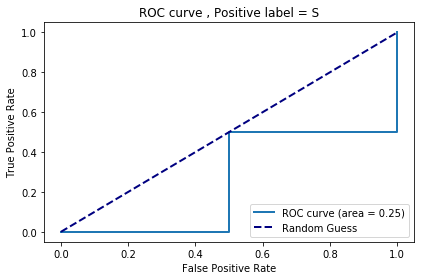

In [17]:
multivariate2b(10, 'linear')


### ¿Qué diferencia encuentra?

### ¿Y si utilizamos el 20% de los features?

,Accuracy,F1,Precision,Recall,ROC AUC
Mean,0.583,0.507867,0.528333,0.534,0.5315
StDev,0.19522,0.298054,0.33471,0.347626,0.304356
Test,0.75,0.666667,1,0.5,1


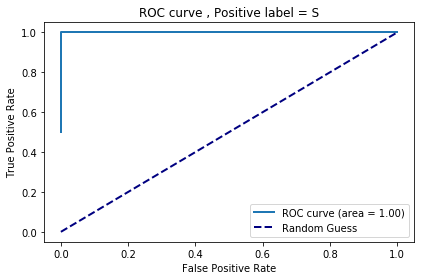

In [18]:
multivariate2b(20, 'linear')


### ¿Qué pasa si probamos y encontramos que utilizando el 35% de los features obtenemos la mejor AUC?

,Accuracy,F1,Precision,Recall,ROC AUC
Mean,0.633,0.54,0.609667,0.529,0.6085
StDev,0.191209,0.299933,0.363663,0.329635,0.283466
Test,0.75,0.666667,1,0.5,0.75


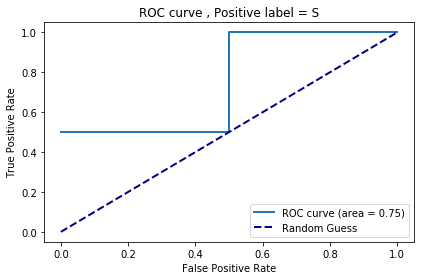

In [19]:
multivariate2b(35, 'linear')
